## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

import scipy.ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.interpolate import splprep, splev
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from skimage.morphology import skeletonize

## Functions

In [4]:
def extract_roi(image, x, y, w, h, line, dark = False):
    #Input: np array of image (bands, pixels, frames)
    # (x,y)= (frames,pixels) top left coordinate of ROI
    # width (w) and height (h) of ROI
    
    #Output: ROI and a bounding box used for imaging the ROI within the original image
    
    roi =  image[y:y+h, x:x+w]
    box = np.copy(image)
    if dark == False:
        intensity = 0
    if dark == True:
        intensity = np.max(image)
    
    box[y:y+line, x:x+w+line] = intensity # top line
    box[y:y+h+line, x:x+line] = intensity # left line
    box[y+h:y+h+line, x:x+w+line] = intensity # bottom line
    box[y:y+h+line, x+w:x+w+line] = intensity # right line
    
    return roi, box

In [6]:
def extract_colors(img, colors, K, iterations = 150, eps = 1e-4, attempts = 50):
    '''Extracts main colors from an image
    
    Parameters: 
    -----------  
        img: Image (h,w,3)
        colors: RGB values main colors
        K: Number of main colors
         
    Returns:  
    --------   
       out: 
       labels_img:
        
    '''
    # Transform image to color vectors
    pixels = img.reshape(-1, 3).astype(np.float32)  # (H*W, 3)
    
    #K-means criteria 
    criteria = ( cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-3)

    # K-means clustering: random initialization, initialize 10 times
    compactness, labels, centers = cv2.kmeans(pixels, K, None, criteria, attempts=20, flags=cv2.KMEANS_RANDOM_CENTERS)
    labels_img = labels.reshape(img.shape[:2])  # (H, W)

    # Match clusters to reference colors
    distances = cdist(centers, colors_meanRGB)
    cluster_to_color = np.argmin(distances, axis=1)

    # Reindex clusters so: cluster index == color index
    color_to_cluster = np.zeros(K, dtype=int) 
    for cluster_idx, color_idx in enumerate(cluster_to_color):
        color_to_cluster[color_idx] = cluster_idx

    # Reorder centers to match colors_meanRGB order
    centers = centers[color_to_cluster]

    # Relabel image
    new_labels_img = np.zeros_like(labels_img)
    for new_idx, old_idx in enumerate(color_to_cluster):
        new_labels_img[labels_img == old_idx] = new_idx

    labels_img = new_labels_img

    # Refill image using aligned indices
    out = np.zeros_like(img, dtype=np.float32)
    for color_idx in range(K):
        out[labels_img == color_idx] = colors_meanRGB[color_idx]

    return out, labels_img

#### Kubelka Munk functions

In [9]:
def transmittance(R, R0, Rg):
    T2 = (R-R0)*(Rg**(-1)-R0)
    return np.sqrt(T2)
    

def R_inf_T(T, R0):
    a = (1+R0**2-T**2)/(2*R0)
    b = np.sqrt(a**2-1)
    R_inf = a - b
    return R_inf

def S_over_K(R_inf):
    return (2*R_inf)/(1-R_inf)**2

def K_and_S(S_K, T, D):
    K = -D**(-1)*np.log(T)
    S = S_K * K
    return K, S

In [11]:
def mark(ax, x, y, label, color, z=None):
    if z is None:  # 2D
        ax.scatter(x, y, c=color, s=20, marker='x')
        ax.annotate(
            label,
            (x, y),
            xytext=(5, 5),
            textcoords="offset points",
            color=color,
            fontsize=11
        )
    else:  # 3D
        ax.scatter(x, y, z, c=color, s=20, marker='x')
        ax.text(
            x, y, z,
            label,
            color=color,
            fontsize=11
        )

## Import Fuji

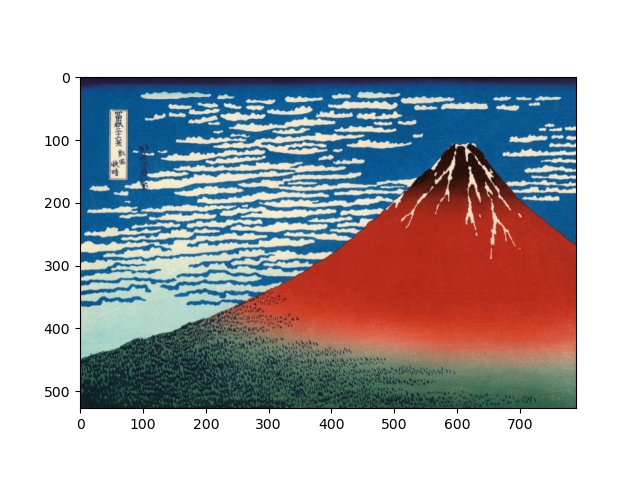

In [14]:
%matplotlib widget

# Load in Red Fuji
img = Image.open("red_fuji.jpg") # Shape (x,y,RGB)
img = np.array(img)/255.0

height, width, _ = img.shape

plt.imshow(img)
plt.show()

## Select Kubelka-Munk values

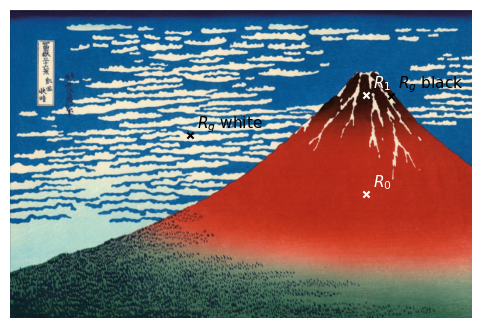

In [189]:
%matplotlib inline

# Indices R1, R0, Rg_black, Rg_white
indx_min = np.array(np.unravel_index(np.argmin(np.sum(img, axis = 2)), (height, width))) #Rg_black
indx_max = np.array(np.unravel_index(np.argmax(np.sum(img, axis = 2)), (height, width))) #Rg_white

y, x = indx_min 
v, u = indx_max
x0 = 608 
y0 = 145
h = 170

Rg_black = img[y,x,:] # minimum value image / closest to (0,0,0)
Rg_white = img[v,u,:] # maximum value image / closest to (1,1,1)
R0 = img[y0, x0, :] # A point that I assume has thickness x and is on Rg_black
R1 = img[y0+h, x0, :] # A point that I assume has thickness x and is on Rg_white

# Plot
fig, ax = plt.subplots(1, figsize = (12,4))
ax.imshow(img)

mark(ax, x, y, r"$R_g$ black", 'k')
mark(ax, u, v, r"$R_g$ white", 'k')
mark(ax, x0, y0+h, r"$R_0$", 'white')
mark(ax, x0, y0, r"$R_1$", 'white')

ax.axis('off')
plt.show()

## Make mountain mask

#### Extract 5 main colors

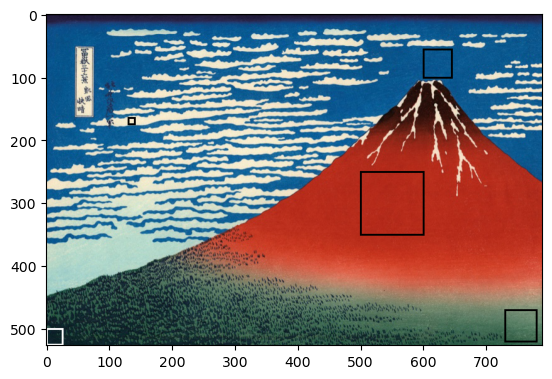

In [193]:
%matplotlib inline

red, box =  extract_roi(img, 500, 250, 100,100, 3)
prussian, box =  extract_roi(box, 600, 55, 45,45, 3)
green, box = extract_roi(box, 730, 470, 50,50, 3)
indigo, box = extract_roi(box, 0, 500, 25,25, 3, dark = True)
white, box = extract_roi(box, 130, 164, 10,10, 3)

colors         =  [white, red, prussian, green, indigo] 
colors_meanRGB =  [] # mean RGB values of those colors

# Calculate mean RGB (mean over spatial dimensions)
for color in colors:
    colors_meanRGB.append(np.mean(color, axis=(0, 1)))

plt.imshow(box)
plt.show()

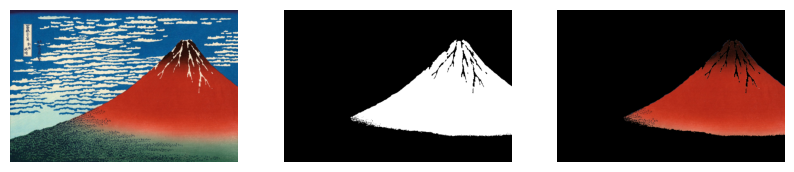

In [195]:
%matplotlib inline

out, labels_img = extract_colors(img, colors_meanRGB, len(colors_meanRGB))

mask_red = labels_img == 1
mask_dark = labels_img == 4

candidate = mask_red | mask_dark

labels, _ = ndi.label(candidate)
valid_labels = np.unique(labels[mask_red])
valid_labels = valid_labels[valid_labels != 0]

mountain_mask = np.isin(labels, valid_labels)

fig, ax = plt.subplots(1,3, figsize = (10,4))
ax[0].imshow(img)
ax[1].imshow(mountain_mask, cmap = 'grey')
ax[2].imshow(img*mountain_mask[:,:,None])

for a in ax:
    a.axis('off')
plt.show()

## Create gradient $R_g$

In [197]:
H, W, _ = img.shape

mountain_mask = mountain_mask.astype(bool)

grad = []
ys = []

for y in range(H):
    row_mask = mountain_mask[y]
    if row_mask.any():
        grad.append(img[y, row_mask].mean(axis=0))
        ys.append(y)

grad = np.array(grad)
ys = np.array(ys)

plt.figure(figsize=(1, 2))
plt.imshow(np.repeat(grad[:,None,:], 20, axis=1))
plt.axis("off")
plt.show()

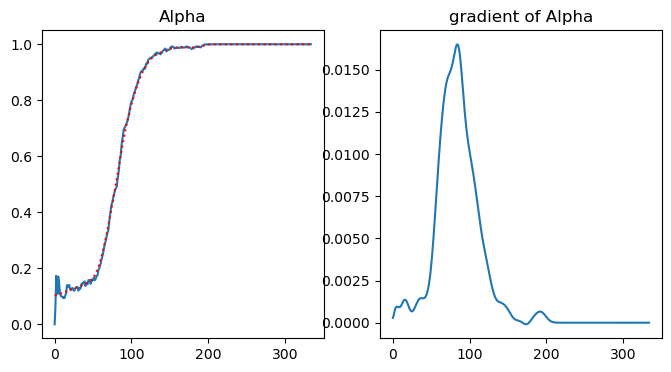

In [255]:
# grad: (N, 3), float in [0,1]

# principal direction of the gradient
v = grad[-1] - grad[0]
v = v / np.linalg.norm(v)

# scalar projection
alpha = (grad - grad[0]) @ v

# normalize to [0,1] and clip 
alpha = (alpha - alpha.min()) / (alpha[:200].max() - alpha.min())
alpha[200:] = 1.0

# Check gradient profile
alpha_smooth = ndi.gaussian_filter1d(alpha, sigma = 6)
alpha_grad = np.gradient(alpha_smooth)


fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].set_title(r'Alpha')
ax[0].plot(alpha)
ax[0].plot(alpha_smooth, linestyle = 'dotted', color = 'r')
ax[1].set_title(r'gradient of Alpha')
ax[1].plot(alpha_grad)
plt.show()

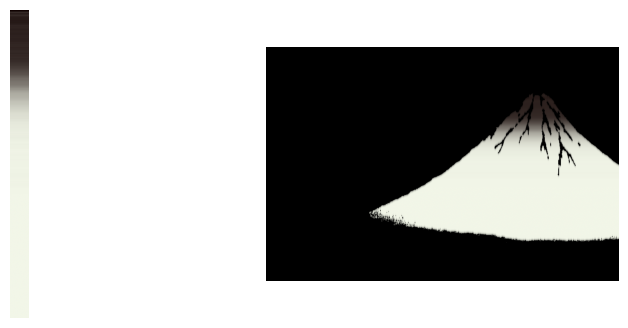

In [257]:
new_grad = (1 - alpha)[:, None] * Rg_black + alpha[:, None] * Rg_white

Rg_mountain = np.zeros_like(img, dtype=float)

ys = np.where(np.sum(mountain_mask, axis=1) > 0)[0]
for i, y in enumerate(ys):
    Rg_mountain[y, mountain_mask[y]] = new_grad[i]

Rg_mountain = ndi.gaussian_filter1d(Rg_mountain, sigma = 2.5, axis = 0)*mountain_mask[:,:,None]

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].imshow(np.repeat(new_grad[:, None, :], 20, axis=1))
ax[0].axis("off")
ax[1].imshow(Rg_mountain)
ax[1].axis('off')
plt.show()

## Layer red pigment on top 

#### Find R_inf 

[0.32493117 0.08232247 0.0381639 ]


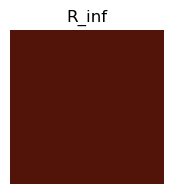

In [259]:
%matplotlib inline
T = transmittance(R1, R0, Rg_white)

R_inf = R_inf_T(T, R0)
S_K = S_over_K(R_inf)

print(R_inf) 

plt.figure(figsize = (2,2))
plt.title(r'R_inf')
plt.imshow(np.ones((5, 5, 3)) * R_inf.reshape(1, 1, 3))
plt.axis('off')
plt.show()

#### Recreate mountain

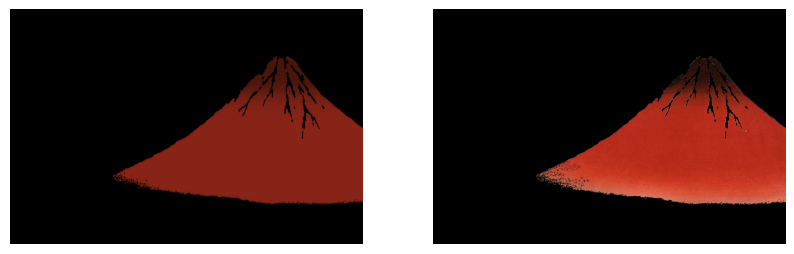

In [290]:
D_factor = 0.2

K_est, S_est = K_and_S(S_K, T, D_factor)

D = np.ones((img.shape[:-1]))* mountain_mask * D_factor

R = rgbkm.reflectance(K_est, S_est, D, Rg_mountain)

fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].imshow(R)
ax[0].axis('off')

ax[1].imshow(img*mountain_mask[:,:,None])
ax[1].axis('off')

plt.show()